In [264]:
%reset -f
import time
t_start = time.time()

In [265]:
import sys
sys.path.insert(0, '../../qe')

import os
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
import shap
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sn
import my_cmaps
from numba import njit

In [266]:
# some constant
GEV = 1e-3
WORKERS = 64
RNG = np.random.default_rng(2024)
path = "./full_345324_data.h5"

In [267]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
model_lead = tf.keras.models.load_model("./dnn_w_lead_full_scaled.h5")
model_lead.summary()
model_sublead = tf.keras.models.load_model("./dnn_w_sublead_full_scaled.h5")
model_sublead.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 2048)              22528     
                                                                 
 dense_14 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_15 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_16 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [268]:
# reco
lead = pd.read_hdf(path, "reco_leadlep")[
    ["RecoLeadLepE", "RecoLeadLepPx", "RecoLeadLepPy", "RecoLeadLepPz"]
]
sublead = pd.read_hdf(path, "reco_subleadlep")[
    ["RecoSubleadLepE", "RecoSubleadLepPx", "RecoSubleadLepPy", "RecoSubleadLepPz"]
]
met = pd.read_hdf(path, "reco_met")[["RecoMETPx", "RecoMETPy"]]

# truth
truth_lead = pd.read_hdf(path, "truth_leadlep")[
    ["TruthRecoLeadLepE", "TruthRecoLeadLepPx", "TruthRecoLeadLepPy", "TruthRecoLeadLepPz"]
]
truth_sublead = pd.read_hdf(path, "truth_subleadlep")[
    ["TruthRecoSubleadLepE", "TruthRecoSubleadLepPx", "TruthRecoSubleadLepPy", "TruthRecoSubleadLepPz"]
]
truth_met = pd.read_hdf(path, "truth_met")[["TruthRecoMETPx", "TruthRecoMETPy"]]

# target Ws
w_lead = pd.read_hdf(path, "truth_leadw")[
    ["TruthRecoLeadWE", "TruthRecoLeadWPx", "TruthRecoLeadWPy", "TruthRecoLeadWPz"]
]
w_sublead = pd.read_hdf(path, "truth_subleadw")[
    [
        "TruthRecoSubleadWE",
        "TruthRecoSubleadWPx",
        "TruthRecoSubleadWPy",
        "TruthRecoSubleadWPz",
    ]
]

obs_var = pd.concat([lead, sublead, met], axis=1) * GEV
truth_obs_var = pd.concat([truth_lead, truth_sublead, truth_met], axis=1) * GEV
int_var_lead = w_lead * GEV
int_var_sublead = w_sublead * GEV

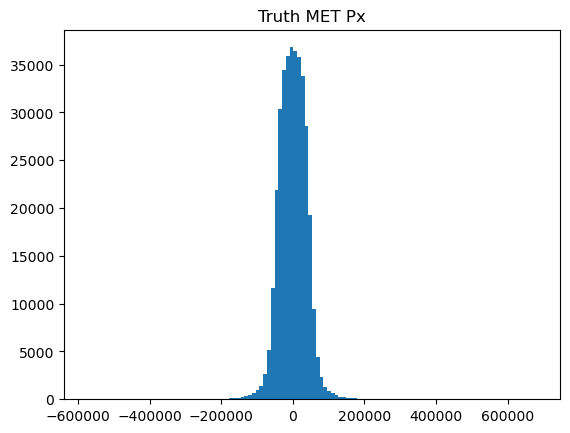

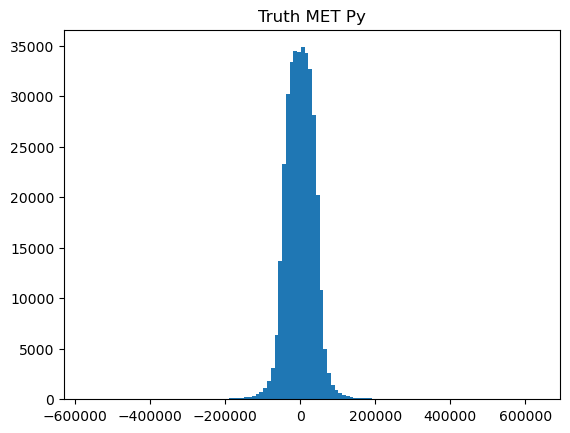

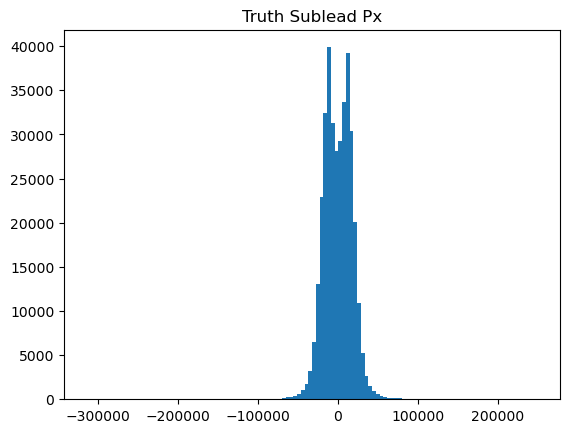

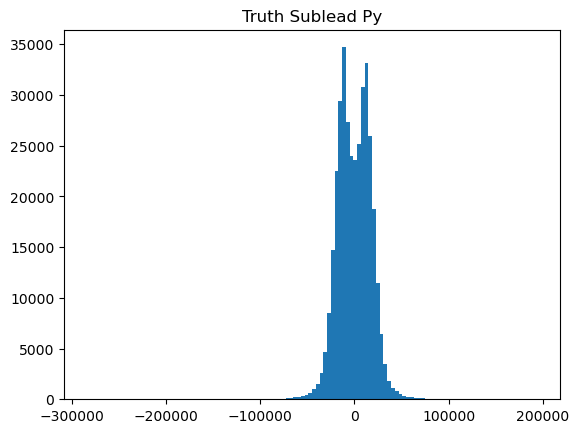

In [269]:
hist = plt.hist(truth_met["TruthRecoMETPx"], bins=120, fill=True)
plt.title("Truth MET Px")
plt.show()
plt.close()
hist = plt.hist(truth_met["TruthRecoMETPy"], bins=120, fill=True)
plt.title("Truth MET Py")
plt.show()
plt.close()
hist = plt.hist(truth_sublead["TruthRecoSubleadLepPx"], bins=120, fill=True)
plt.title("Truth Sublead Px")
plt.show()
plt.close()
hist = plt.hist(truth_sublead["TruthRecoSubleadLepPy"], bins=120, fill=True)
plt.title("Truth Sublead Py")
plt.show()
plt.close()

In [270]:
# reco
ROBUST_OBS = RobustScaler()
obs_var = ROBUST_OBS.fit_transform(obs_var)
# truth
TRUTH_ROBUST_OBS = RobustScaler()
truth_obs_var = TRUTH_ROBUST_OBS.fit_transform(truth_obs_var)

ROBUST_INT_LEAD = RobustScaler().fit(int_var_lead)
int_var_lead = int_var_lead.to_numpy()
ROBUST_INT_SUBLEAD = RobustScaler().fit(int_var_sublead)
int_var_sublead = int_var_sublead.to_numpy()

In [271]:
# reco
pred_int_lead = model_lead.predict(obs_var)
pred_int_lead = ROBUST_INT_LEAD.inverse_transform(pred_int_lead)
pred_int_sublead = model_sublead.predict(obs_var)
pred_int_sublead = ROBUST_INT_SUBLEAD.inverse_transform(pred_int_sublead)
# truth
truth_pred_int_lead = model_lead.predict(truth_obs_var)
truth_pred_int_lead = ROBUST_INT_LEAD.inverse_transform(truth_pred_int_lead)
truth_pred_int_sublead = model_sublead.predict(truth_obs_var)
truth_pred_int_sublead = ROBUST_INT_SUBLEAD.inverse_transform(truth_pred_int_sublead)


11188/11188 [==============================] - 18s 2ms/step


In [272]:
# reco
lead_lep = lead[
    [
        "RecoLeadLepPx",
        "RecoLeadLepPy",
        "RecoLeadLepPz",
        "RecoLeadLepE",
    ]
].to_numpy()
sublead_lep = sublead[
    [
        "RecoSubleadLepPx",
        "RecoSubleadLepPy",
        "RecoSubleadLepPz",
        "RecoSubleadLepE",
    ]
].to_numpy()
pred_w_lead_energy = pred_int_lead[:, 0]
pred_w_lead_px = pred_int_lead[:, 1]
pred_w_lead_py = pred_int_lead[:, 2]
pred_w_lead_pz = pred_int_lead[:, 3]
pred_w_lead_p4 = np.vstack(
    [pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz, pred_w_lead_energy]
).T
pred_w_sublead_energy = pred_int_sublead[:, 0]
pred_w_sublead_px = pred_int_sublead[:, 1]
pred_w_sublead_py = pred_int_sublead[:, 2]
pred_w_sublead_pz = pred_int_sublead[:, 3]
pred_w_sublead_p4 = np.vstack(
    [pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz, pred_w_sublead_energy]
).T

In [273]:
# truth
truth_lead_lep = truth_lead[
    [
        "TruthRecoLeadLepPx",
        "TruthRecoLeadLepPy",
        "TruthRecoLeadLepPz",
        "TruthRecoLeadLepE",
    ]
].to_numpy()
truth_sublead_lep = truth_sublead[
    [
        "TruthRecoSubleadLepPx",
        "TruthRecoSubleadLepPy",
        "TruthRecoSubleadLepPz",
        "TruthRecoSubleadLepE",
    ]
].to_numpy()
truth_pred_w_lead_energy = truth_pred_int_lead[:, 0]
truth_pred_w_lead_px = truth_pred_int_lead[:, 1]
truth_pred_w_lead_py = truth_pred_int_lead[:, 2]
truth_pred_w_lead_pz = truth_pred_int_lead[:, 3]
truth_pred_w_lead_p4 = np.vstack(
    [truth_pred_w_lead_px, truth_pred_w_lead_py, truth_pred_w_lead_pz, truth_pred_w_lead_energy]
).T
truth_pred_w_sublead_energy = truth_pred_int_sublead[:, 0]
truth_pred_w_sublead_px = truth_pred_int_sublead[:, 1]
truth_pred_w_sublead_py = truth_pred_int_sublead[:, 2]
truth_pred_w_sublead_pz = truth_pred_int_sublead[:, 3]
truth_pred_w_sublead_p4 = np.vstack(
    [truth_pred_w_sublead_px, truth_pred_w_sublead_py, truth_pred_w_sublead_pz, truth_pred_w_sublead_energy]
).T

In [274]:
# raw Ws
raw_w_lead_p4 = GEV * w_lead[["TruthRecoLeadWPx", "TruthRecoLeadWPy", "TruthRecoLeadWPz", "TruthRecoLeadWE"]].to_numpy()
raw_w_sublead_p4 = GEV * w_sublead[["TruthRecoSubleadWPx", "TruthRecoSubleadWPy", "TruthRecoSubleadWPz", "TruthRecoSubleadWE"]].to_numpy()

In [275]:
def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

In [276]:
def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 4.1 test: which lepton nan when boost to W+ and W- frame
    if np.isnan(WpLp_k.Mag()) or np.isnan(WnLp_k.Mag()):
        nan_test = 1
    else:
        nan_test = 0
    
    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
        np.array([nan_test, nan_test, nan_test])
    )

In [277]:
def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    nan_test = np.zeros((particles.shape[0], 3))
    # bunch them together
    result = np.array((particles.shape[0], 3, 6))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(Bij, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    nan_test = np.sum(result[:, 5], axis=1) != 0
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
        nan_test,
    )

In [278]:
# reco
particles = np.concatenate(
    [pred_w_lead_p4, lead_lep, pred_w_sublead_p4, sublead_lep], axis=1
)
(
    bij_cleaned,
    xi_lead_cleaned,
    xi_sublead_cleaned,
    ggm_lead_cleaned,
    ggm_sublead_cleaned,
    mask,
    nan_test,
) = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(mask == nan_test))

# truth
particles = np.concatenate(
    [truth_pred_w_lead_p4, truth_lead_lep, truth_pred_w_sublead_p4, truth_sublead_lep],
    axis=1,
)
(
    truth_bij_cleaned,
    truth_xi_lead_cleaned,
    truth_xi_sublead_cleaned,
    truth_ggm_lead_cleaned,
    truth_ggm_sublead_cleaned,
    truth_mask,
    truth_nan_test,
) = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(truth_mask == truth_nan_test))

# raw
particles = np.concatenate(
    [raw_w_lead_p4, truth_lead_lep, raw_w_sublead_p4, truth_sublead_lep], axis=1
)
bij, xi_lead, xi_sublead, ggm_lead, ggm_sublead, mask_raw, nan_test_raw = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(mask_raw == nan_test_raw))

True
True
True


In [279]:
def test(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()

    return WpLepton, WnLepton


def test_generator(particles):

    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(test, particles)))

    return result


# __main__
test_particles = np.concatenate(
    [pred_w_lead_p4, lead_lep, pred_w_sublead_p4, sublead_lep], axis=1
)
test_result = test_generator(test_particles)

In [280]:
# def rotate(lp_theta, lp_phi, ln_theta, ln_phi):
#     lp_theta_0toPi = np.where(
#         lp_theta < 0, np.pi + lp_theta, lp_theta
#     )  # map [-pi/2 , pi/2] to [0,  pi]
#     ln_theta_0toPi = np.where(
#         ln_theta < 0, np.pi + ln_theta, ln_theta
#     )  # map [-pi/2 , pi/2] to [0,  pi]
#     lp_phi_0to2Pi = np.where(
#         lp_phi < 0, 2 * np.pi + lp_phi, lp_phi
#     )  # map [-pi   , pi  ] to [0, 2pi]
#     ln_phi_0to2Pi = np.where(
#         ln_phi < 0, 2 * np.pi + ln_phi, ln_phi
#     )  # map [-pi   , pi  ] to [0, 2pi]
#     return lp_theta_0toPi, lp_phi_0to2Pi, ln_theta_0toPi, ln_phi_0to2Pi

In [281]:
def C_matrix(lp_theta, lp_phi, ln_theta, ln_phi):

    lp_theta_0toPi = np.where(
        lp_theta < 0, np.pi + lp_theta, lp_theta
    )  # map [-pi/2 , pi/2] to [0,  pi]
    ln_theta_0toPi = np.where(
        ln_theta < 0, np.pi + ln_theta, ln_theta
    )  # map [-pi/2 , pi/2] to [0,  pi]
    lp_phi_0to2Pi = np.where(
        lp_phi < 0, 2 * np.pi + lp_phi, lp_phi
    )  # map [-pi   , pi  ] to [0, 2pi]
    ln_phi_0to2Pi = np.where(
        ln_phi < 0, 2 * np.pi + ln_phi, ln_phi
    )  # map [-pi   , pi  ] to [0, 2pi]

    PSymb = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
    WignerPp = pd.DataFrame()
    WignerPn = pd.DataFrame()
    for i, Phi in enumerate([P1, P2, P3, P4, P5, P6, P7, P8]):
        WignerPp[PSymb[i] + "+"] = Phi(lp_theta_0toPi, lp_phi_0to2Pi, "pos")
        WignerPn[PSymb[i] + "-"] = Phi(ln_theta_0toPi, ln_phi_0to2Pi, "neg")

    C = np.zeros(shape=(9, 9))
    for i in range(8):
        C[0, i + 1] = np.mean(WignerPp.iloc[:, i]) * 0.5
        C[i + 1, 0] = np.mean(WignerPn.iloc[:, i]) * 0.5
        for j in range(8):
            C[i + 1, j + 1] = np.mean(WignerPn.iloc[:, i] * WignerPp.iloc[:, j]) * 0.25

    return C, WignerPp, WignerPn

In [282]:
# reco
lead_phi, lead_theta = ggm_lead_cleaned[:, 1], ggm_lead_cleaned[:, 2]
sublead_phi, sublead_theta = ggm_sublead_cleaned[:, 1], ggm_sublead_cleaned[:, 2]

# truth
truth_lead_phi, truth_lead_theta = (
    truth_ggm_lead_cleaned[:, 1],
    truth_ggm_lead_cleaned[:, 2],
)
truth_sublead_phi, truth_sublead_theta = (
    truth_ggm_sublead_cleaned[:, 1],
    truth_ggm_sublead_cleaned[:, 2],
)

# raw
raw_lead_phi, raw_lead_theta = ggm_lead[:, 1], ggm_lead[:, 2]
raw_sublead_phi, raw_sublead_theta = ggm_sublead[:, 1], ggm_sublead[:, 2]

In [283]:
# reco
C, WignerPp, WignerPn = C_matrix(lead_theta, lead_phi, sublead_theta, sublead_phi)
# truth
truth_C, truth_WignerPp, truth_WignerPn = C_matrix(
    truth_lead_theta, truth_lead_phi, truth_sublead_theta, truth_sublead_phi
)
# raw
raw_C, raw_WignerPp, raw_WignerPn = C_matrix(
    raw_lead_theta, raw_lead_phi, raw_sublead_theta, raw_sublead_phi
)

In [284]:
def ggm_plot(C, title="RAW"):
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120)
    xx, yy = np.meshgrid(np.arange(9), np.arange(9))
    im = ax.pcolormesh(
        xx, yy, C, cmap=my_cmaps.hotcold(neutral=1.0), vmin=-0.25, vmax=0.25, shading="auto"
    )
    ax.set_aspect(1)
    # Remove the tick lines
    ax.tick_params(axis="both", which="minor", tick1On=False, tick2On=False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax, orientation="vertical")
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_verticalalignment("center")
    for label in ax.get_yticklabels(minor=True):
        label.set_horizontalalignment("center")
    ax.set_xticks(np.arange(9))
    ax.set_xlabel(r"lead-lep $W$ GM index", fontsize=12)
    ax.set_ylabel(r"sublead-lep $W$ GM index", fontsize=12)
    ax.set_title(f"{title} " + r"$pp\to H \to WW^* \to \ell \nu \ell \nu$", fontsize=16)
    plt.show()
    plt.close()

In [285]:
# # reco
# ggm_plot(C, "RECO")
# # truth
# ggm_plot(truth_C, "TRUTH")
# # raw
# ggm_plot(raw_C, "RAW")

In [286]:
# def ci(data):
#     res = stats.bootstrap(
#         (data,),
#         statistic=np.mean,
#         confidence_level=0.95,
#         n_resamples=1_024,
#         vectorized=True,
#         alternative="two-sided",
#         method="BCa",
#         random_state=RNG,
#         batch=16_384,
#     )
#     return res.confidence_interval

In [287]:
# with multiprocessing.Pool(WORKERS) as pool:
#     reco_ci = pool.map(ci, bij_cleaned.T)
#     reco_ci_xy_low, reco_ci_xy_high = reco_ci[0][0], reco_ci[0][1]
#     reco_ci_yz_low, reco_ci_yz_high = reco_ci[1][0], reco_ci[1][1]
#     reco_ci_zx_low, reco_ci_zx_high = reco_ci[2][0], reco_ci[2][1]
# print(
#     f"""
# <RECO>: EVT_NUM: {len(bij_cleaned)}
# Bxy: mean = {bij_cleaned[:, 0].mean():<.3f} with 95%CI: -{bij_cleaned[:, 0].mean() - reco_ci_xy_low:<.3f}; +{reco_ci_xy_high - bij_cleaned[:, 0].mean():<.3f}
# Byz: mean = {bij_cleaned[:, 1].mean():<.3f} with 95%CI: -{bij_cleaned[:, 1].mean() - reco_ci_yz_low:<.3f}; +{reco_ci_yz_high - bij_cleaned[:, 1].mean():<.3f}
# Bzx: mean = {bij_cleaned[:, 2].mean():<.3f} with 95%CI: -{bij_cleaned[:, 2].mean() - reco_ci_zx_low:<.3f}; +{reco_ci_zx_high - bij_cleaned[:, 2].mean():<.3f}"""
# )

# truth_Bij = pd.read_hdf(path, "truth_Bij")
# truth_Bij = truth_Bij.to_numpy()
# with multiprocessing.Pool(WORKERS) as pool:
#     truth_ci = pool.map(ci, truth_Bij.T)
#     truth_ci_xy_low, truth_ci_xy_high = truth_ci[0][0], truth_ci[0][1]
#     truth_ci_yz_low, truth_ci_yz_high = truth_ci[1][0], truth_ci[1][1]
#     truth_ci_zx_low, truth_ci_zx_high = truth_ci[2][0], truth_ci[2][1]
# print(
#     f"""
# <TRUTH>: EVT_NUM: {len(truth_Bij)}
# Bxy: mean = {truth_Bij[:, 0].mean():<.3f} with 95%CI: -{truth_Bij[:, 0].mean() - truth_ci_xy_low:<.3f}; +{truth_ci_xy_high - truth_Bij[:, 0].mean():<.3f}
# Byz: mean = {truth_Bij[:, 1].mean():<.3f} with 95%CI: -{truth_Bij[:, 1].mean() - truth_ci_yz_low:<.3f}; +{truth_ci_yz_high - truth_Bij[:, 1].mean():<.3f}
# Bzx: mean = {truth_Bij[:, 2].mean():<.3f} with 95%CI: -{truth_Bij[:, 2].mean() - truth_ci_zx_low:<.3f}; +{truth_ci_zx_high - truth_Bij[:, 2].mean():<.3f}"""
# )

In [288]:
from sklearn.metrics import mean_squared_error


truth_Bij = pd.read_hdf(path, "truth_Bij")


def der_org_plot(
    reco_data,
    truth_data,
    title="Bxy",
    raw_data=truth_Bij["Bxy"],
    unit=None,
    rmse=False,
    density=True,
):
    bins = 60
    plt.figure(figsize=(7, 5), dpi=100)
    hist = plt.hist(
        reco_data,
        density=density,
        bins=bins,
        color="r",
        histtype="step",
        alpha=1,
        label="Reco",
    )
    hist = plt.hist(
        truth_data,
        density=density,
        bins=bins,
        color="b",
        histtype="step",
        alpha=1,
        label="True",
    )
    if raw_data is not None:
        hist = plt.hist(
            raw_data,
            density=density,
            bins=bins,
            color="grey",
            alpha=0.2,
            fill=True,
            label="label",
        )
    if unit is None:
        plt.xlabel("Null", fontsize=12)
    else:
        plt.xlabel(unit, fontsize=12)
    plt.ylabel("Norm. Count", fontsize=12)
    if rmse is True:
        plt.title(
            title
            + f" with RMSE: {np.sqrt(mean_squared_error(truth_data, reco_data)):.3f}",
            fontsize=16,
        )
    else:
        plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

In [289]:
# der_org_plot(bij_cleaned[:, 0], truth_bij_cleaned[:, 0], r"$B_{xy}$", truth_Bij["Bxy"], rmse=False)
# der_org_plot(bij_cleaned[:, 1], truth_bij_cleaned[:, 1], r"$B_{yz}$", truth_Bij["Byz"], rmse=False)
# der_org_plot(bij_cleaned[:, 2], truth_bij_cleaned[:, 2], r"$B_{zx}$", truth_Bij["Bzx"], rmse=False)

In [290]:
# der_org_plot(xi_lead_cleaned[:, 0], truth_xi_lead_cleaned[:, 0], r"$\xi^{lead}_{x}$", raw_data=xi_lead[:, 0])
# der_org_plot(xi_lead_cleaned[:, 1], truth_xi_lead_cleaned[:, 1], r"$\xi^{lead}_{y}$", raw_data=xi_lead[:, 1])
# der_org_plot(xi_lead_cleaned[:, 2], truth_xi_lead_cleaned[:, 2], r"$\xi^{lead}_{z}$", raw_data=xi_lead[:, 2])

In [291]:
# der_org_plot(xi_sublead_cleaned[:, 0], truth_xi_sublead_cleaned[:, 0], r"$\xi^{sublead}_{x}$", raw_data=xi_sublead[:, 0])
# der_org_plot(xi_sublead_cleaned[:, 1], truth_xi_sublead_cleaned[:, 1], r"$\xi^{sublead}_{y}$", raw_data=xi_sublead[:, 1])
# der_org_plot(xi_sublead_cleaned[:, 2], truth_xi_sublead_cleaned[:, 2], r"$\xi^{sublead}_{z}$", raw_data=xi_sublead[:, 2])

In [292]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))

# def eta(px, py, pz):
#     p = np.sqrt(np.square(px) + np.square(py) + np.square(pz))
#     return np.arctanh(np.divide(pz, p))

def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))

# def phi(px, py):
#     pt = np.sqrt(np.square(px) + np.square(py))
#     return np.arccos(np.divide(px, pt))

def phi(px, py):
    return np.arctan2(py, px)

In [293]:
# leading
# reco
w_lead_pt = pt(pred_w_lead_px, pred_w_lead_py)
w_lead_eta = eta(pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz)
w_lead_phi = phi(pred_w_lead_px, pred_w_lead_py)
# truth
truth_w_lead_pt = pt(truth_pred_w_lead_px, truth_pred_w_lead_py)
truth_w_lead_eta = eta(truth_pred_w_lead_px, truth_pred_w_lead_py, truth_pred_w_lead_pz)
truth_w_lead_phi = phi(truth_pred_w_lead_px, truth_pred_w_lead_py)
# raw
raw_w_lead_pt = pt(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])
raw_w_lead_eta = eta(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1], raw_w_lead_p4[:, 2])
raw_w_lead_phi = phi(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])

# subleading
# reco
w_sublead_pt = pt(pred_w_sublead_px, pred_w_sublead_py)
w_sublead_eta = eta(pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz)
w_sublead_phi = phi(pred_w_sublead_px, pred_w_sublead_py)
# truth
truth_w_sublead_pt = pt(truth_pred_w_sublead_px, truth_pred_w_sublead_py)
truth_w_sublead_eta = eta(truth_pred_w_sublead_px, truth_pred_w_sublead_py, truth_pred_w_sublead_pz)
truth_w_sublead_phi = phi(truth_pred_w_sublead_px, truth_pred_w_sublead_py)
# raw
raw_w_sublead_pt = pt(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])
raw_w_sublead_eta = eta(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1], raw_w_sublead_p4[:, 2])
raw_w_sublead_phi = phi(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])

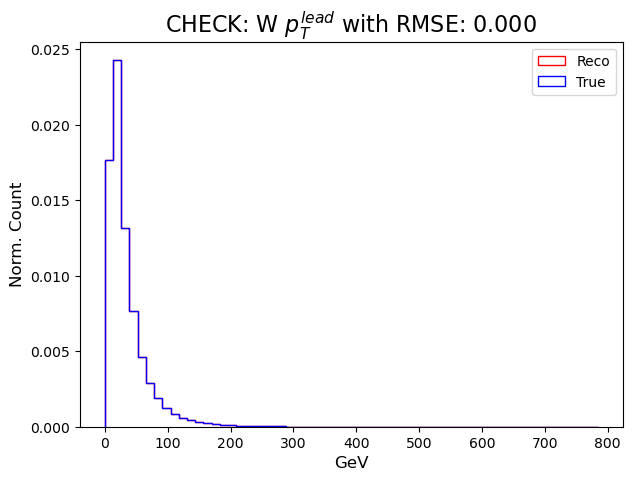

In [294]:
check_pt = np.zeros(pred_w_lead_px.shape[0])
check_eta = np.zeros(pred_w_lead_px.shape[0])
check_phi = np.zeros(pred_w_lead_px.shape[0])
for i in range(pred_w_lead_px.shape[0]):
	check_pt[i] = pt(pred_w_lead_px[i], pred_w_lead_py[i])
	check_eta[i] = eta(pred_w_lead_px[i], pred_w_lead_py[i], pred_w_lead_pz[i])
	check_phi[i] = phi(pred_w_lead_px[i], pred_w_lead_py[i])
der_org_plot(w_lead_pt, check_pt, r"CHECK: W $p_{T}^{lead}$", raw_data=None, unit="GeV", rmse=True)

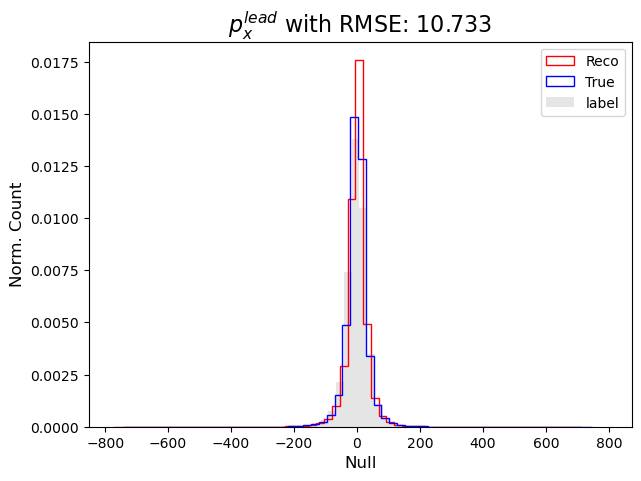

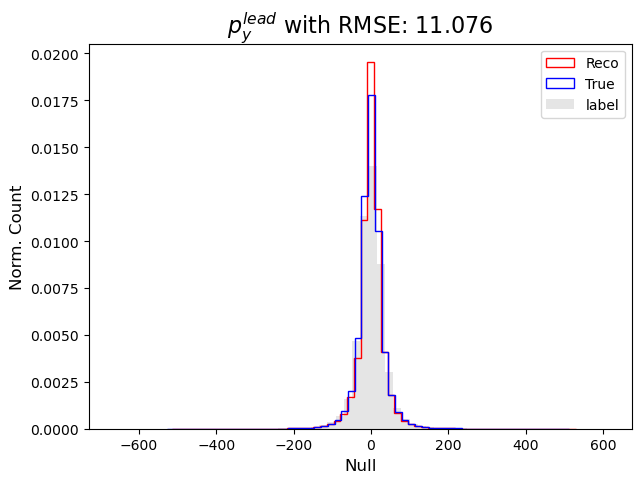

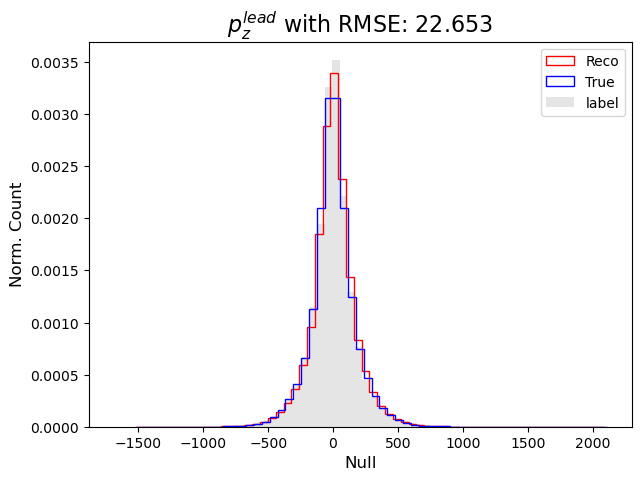

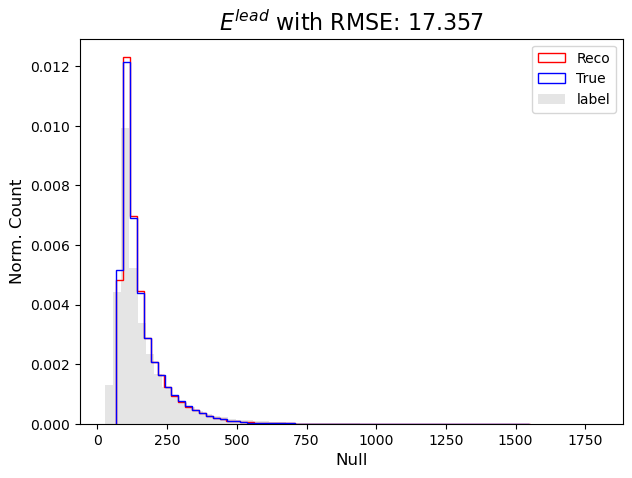

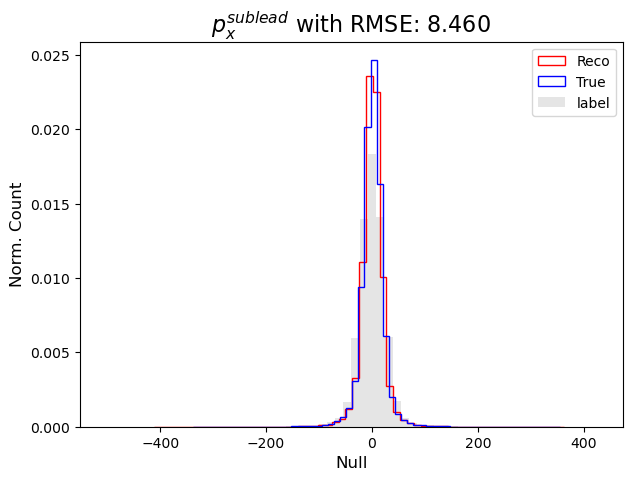

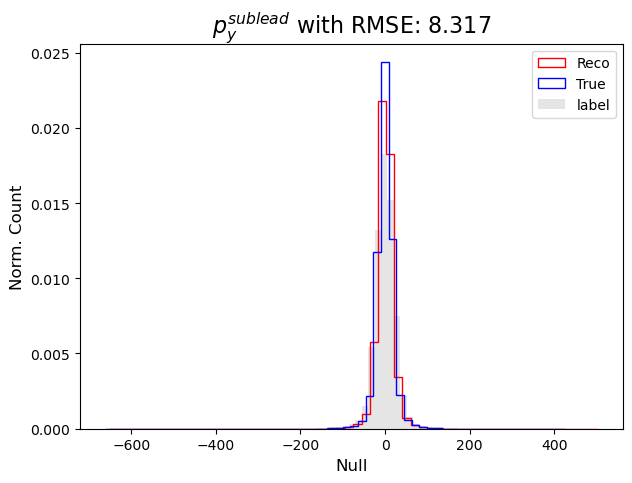

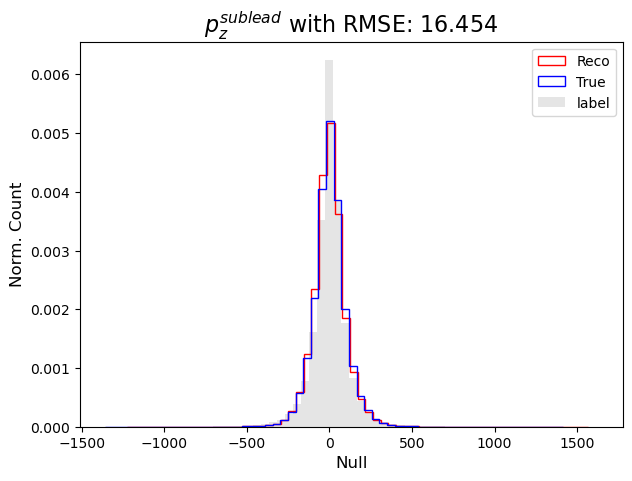

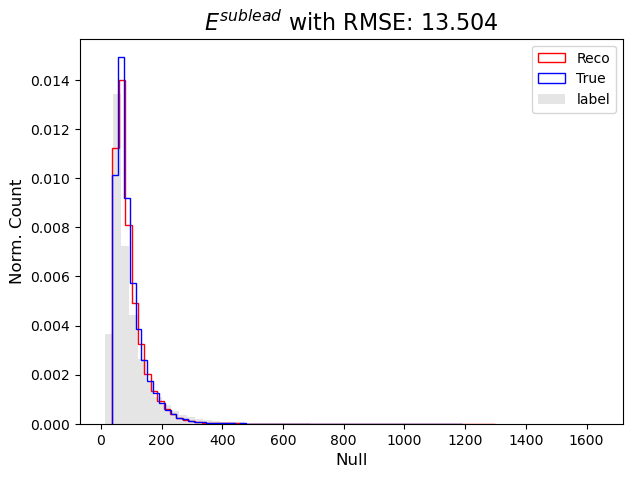

In [295]:
# lead
der_org_plot(pred_w_lead_px, truth_pred_w_lead_px, r"$p_{x}^{lead}$", raw_data=raw_w_lead_p4[:, 0], rmse=True)
der_org_plot(pred_w_lead_py, truth_pred_w_lead_py, r"$p_{y}^{lead}$", raw_data=raw_w_lead_p4[:, 1], rmse=True)
der_org_plot(pred_w_lead_pz, truth_pred_w_lead_pz, r"$p_{z}^{lead}$", raw_data=raw_w_lead_p4[:, 2], rmse=True)
der_org_plot(pred_w_lead_energy, truth_pred_w_lead_energy, r"$E^{lead}$", raw_data=raw_w_lead_p4[:, 3], rmse=True)
# sublead
der_org_plot(pred_w_sublead_px, truth_pred_w_sublead_px, r"$p_{x}^{sublead}$", raw_data=raw_w_sublead_p4[:, 0], rmse=True)
der_org_plot(pred_w_sublead_py, truth_pred_w_sublead_py, r"$p_{y}^{sublead}$", raw_data=raw_w_sublead_p4[:, 1], rmse=True)
der_org_plot(pred_w_sublead_pz, truth_pred_w_sublead_pz, r"$p_{z}^{sublead}$", raw_data=raw_w_sublead_p4[:, 2], rmse=True)
der_org_plot(pred_w_sublead_energy, truth_pred_w_sublead_energy, r"$E^{sublead}$", raw_data=raw_w_sublead_p4[:, 3], rmse=True)

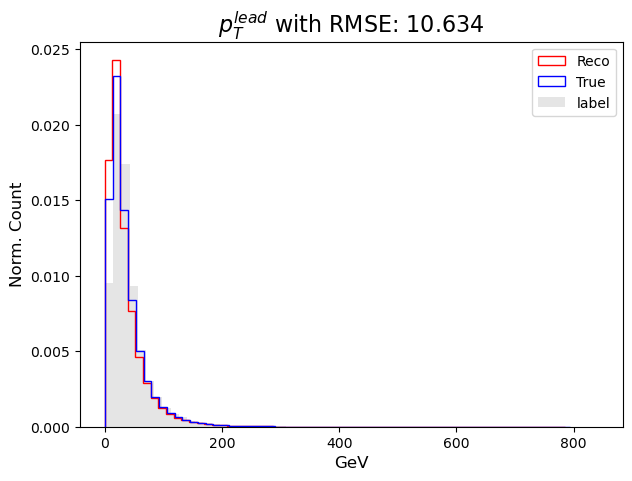

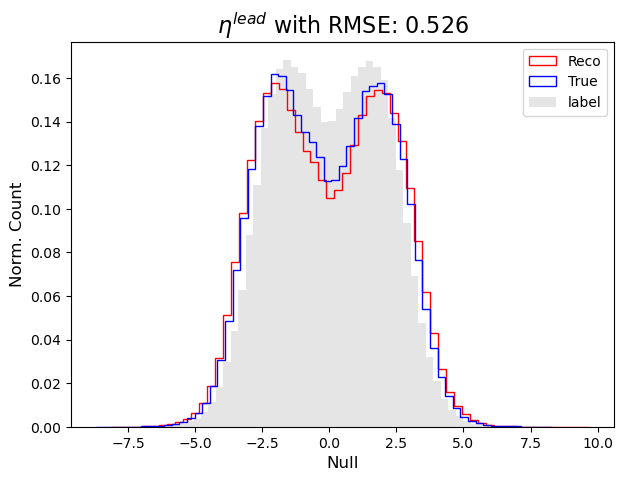

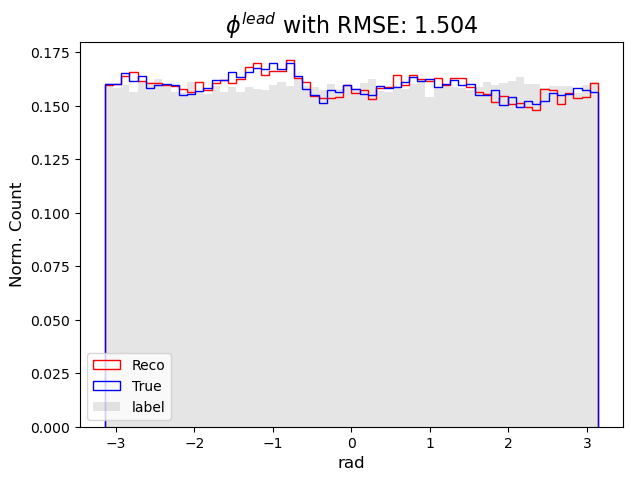

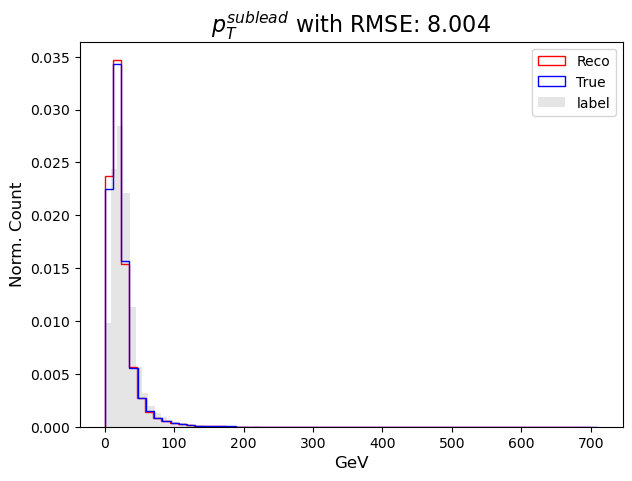

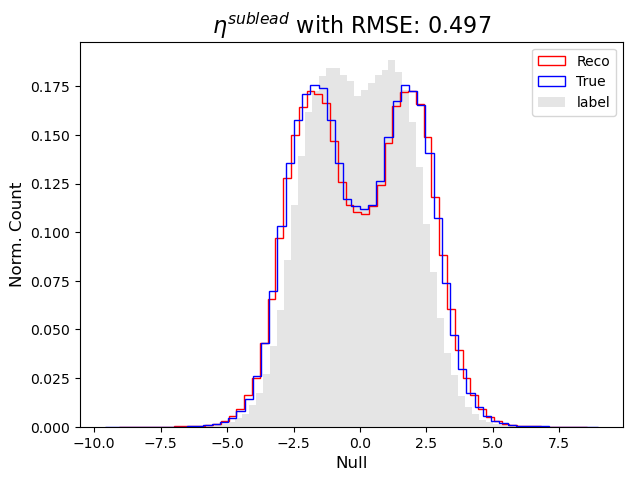

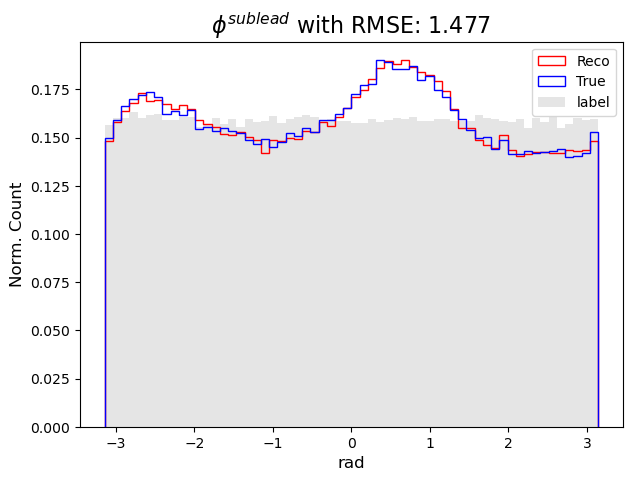

In [296]:
#   leading
der_org_plot(w_lead_pt, truth_w_lead_pt, r"$p^{lead}_{T}$", unit="GeV", raw_data=raw_w_lead_pt, rmse=True)
der_org_plot(w_lead_eta, truth_w_lead_eta, r"$\eta^{lead}$", raw_data=raw_w_lead_eta, rmse=True)
der_org_plot(w_lead_phi, truth_w_lead_phi, r"$\phi^{lead}$", unit="rad", raw_data=raw_w_lead_phi, rmse=True)
# subleading
der_org_plot(w_sublead_pt, truth_w_sublead_pt, r"$p^{sublead}_{T}$", unit="GeV", raw_data=raw_w_sublead_pt, rmse=True)
der_org_plot(w_sublead_eta, truth_w_sublead_eta, r"$\eta^{sublead}$", raw_data=raw_w_sublead_eta, rmse=True)
der_org_plot(w_sublead_phi, truth_w_sublead_phi, r"$\phi^{sublead}$", unit="rad", raw_data=raw_w_sublead_phi, rmse=True)

In [297]:
name = ["px", "py", "pz", "E"]
lead_w = dict(zip(name, raw_w_lead_p4))
sublead_w = dict(zip(name, raw_w_sublead_p4))
name = ["lead_E", "lead_px", "lead_py", "lead_pz", "sublead_E", "sublead_px", "sublead_py", "sublead_pz", "met_px", "met_py", "w_px", "w_py", "w_pz", "w_E"]
lead_model = dict(zip(name, np.concatenate([lead_lep, sublead_lep, met, raw_w_lead_p4], axis=1)))
sublead_model = dict(zip(name, np.concatenate([lead_lep, sublead_lep, met, raw_w_sublead_p4], axis=1)))

In [298]:
# feature_names = [
#     "lead_E",
#     "lead_px",
#     "lead_py",
#     "lead_pz",
#     "sublead_E",
#     "sublead_px",
#     "sublead_py",
#     "sublead_pz",
#     "met_px",
#     "met_py",
# ]
# # lead
# # Use DeepExplainer for SHAP values
# explainer = shap.DeepExplainer(model_lead, obs_var[:1_024])
# shap_values = explainer.shap_values(obs_var[:1_024])
# for i in range(shap_values.shape[-1]):
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values[:, :, i], obs_var[:1_024],
#         feature_names=feature_names,
#         plot_type="dot",
#         show=False
#     )
#     plt.title(f"SHAP Summary Plot for Lead Output: {feature_names[i]}") 
#     plt.show()
# # sublead
# # Use DeepExplainer for SHAP values
# explainer = shap.DeepExplainer(model_sublead, obs_var[:1_024])
# shap_values = explainer.shap_values(obs_var[:1_024])
# for i in range(shap_values.shape[-1]):
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values[:, :, i], obs_var[:1_024],
#         feature_names=feature_names,
#         plot_type="dot",
#         show=False
#     )
#     plt.title(f"SHAP Summary Plot for Sublead Output: {feature_names[i+4]}") 
#     plt.show()

In [299]:
w_name = ["px", "py", "pz", "E"]
name = ["lead_E", "lead_px", "lead_py", "lead_pz", "sublead_E", "sublead_px", "sublead_py", "sublead_pz", "met_px", "met_py", "w_px", "w_py", "w_pz", "w_E"]

lead_w = pd.DataFrame({w_name[i]: pred_w_lead_p4[:, i] for i in range(4)})
sublead_w = pd.DataFrame({w_name[i]: pred_w_sublead_p4[:, i] for i in range(4)})
pred_lead_w = pd.DataFrame({name[i]: np.concatenate([lead_lep, sublead_lep, met, pred_w_lead_p4], axis=1)[:, i] for i in range(14)})
pred_sublead_w = pd.DataFrame({name[i]: np.concatenate([lead_lep, sublead_lep, met, pred_w_sublead_p4], axis=1)[:, i] for i in range(14)})

In [300]:
truth_lead_w = pd.DataFrame({w_name[i]: truth_pred_w_lead_p4[:, i] for i in range(4)})
truth_sublead_w = pd.DataFrame({w_name[i]: truth_pred_w_sublead_p4[:, i] for i in range(4)})
pred_truth_lead_w = pd.DataFrame({name[i]: np.concatenate([lead_lep, sublead_lep, met, truth_pred_w_lead_p4], axis=1)[:, i] for i in range(14)})
pred_truth_sublead_w = pd.DataFrame({name[i]: np.concatenate([lead_lep, sublead_lep, met, truth_pred_w_sublead_p4], axis=1)[:, i] for i in range(14)})

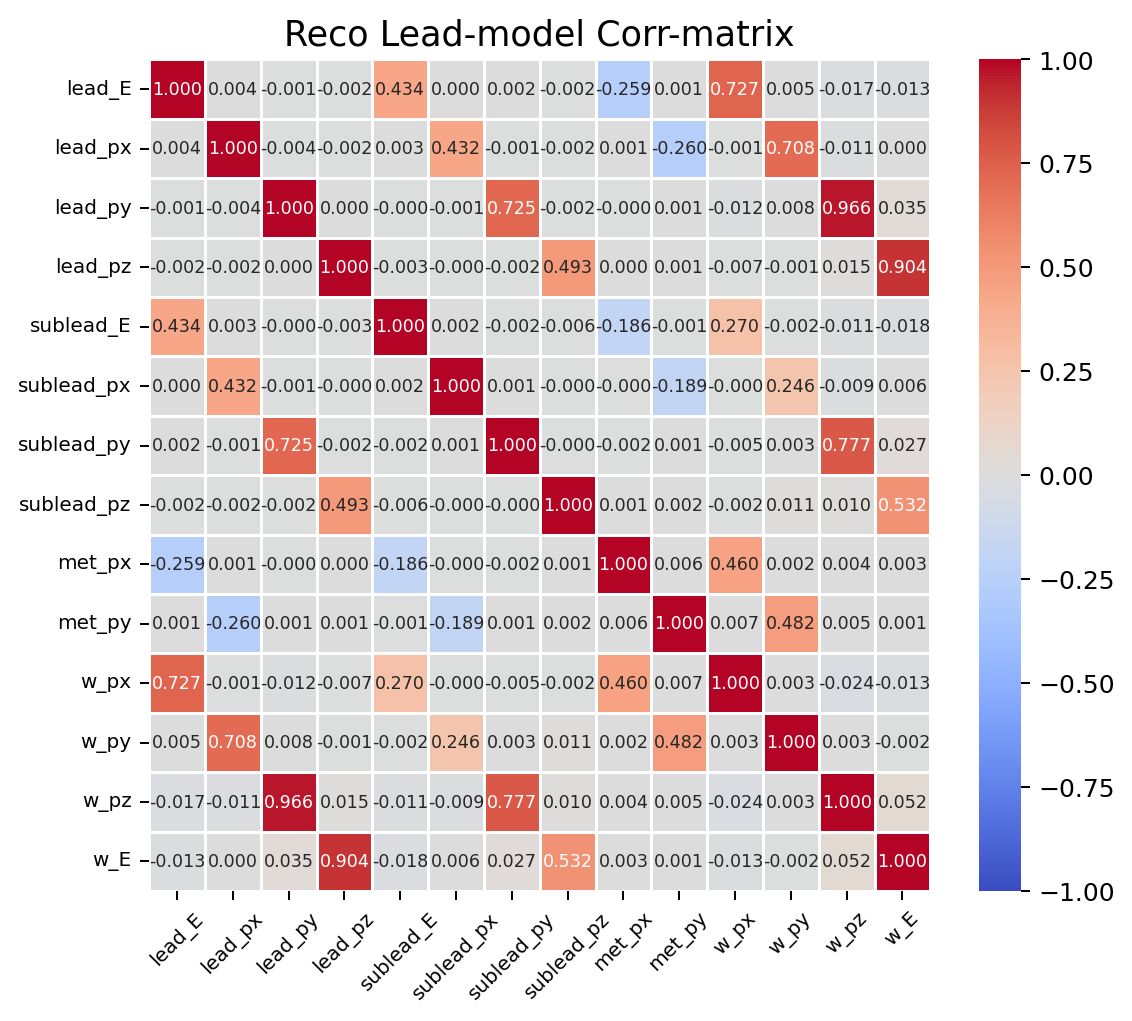

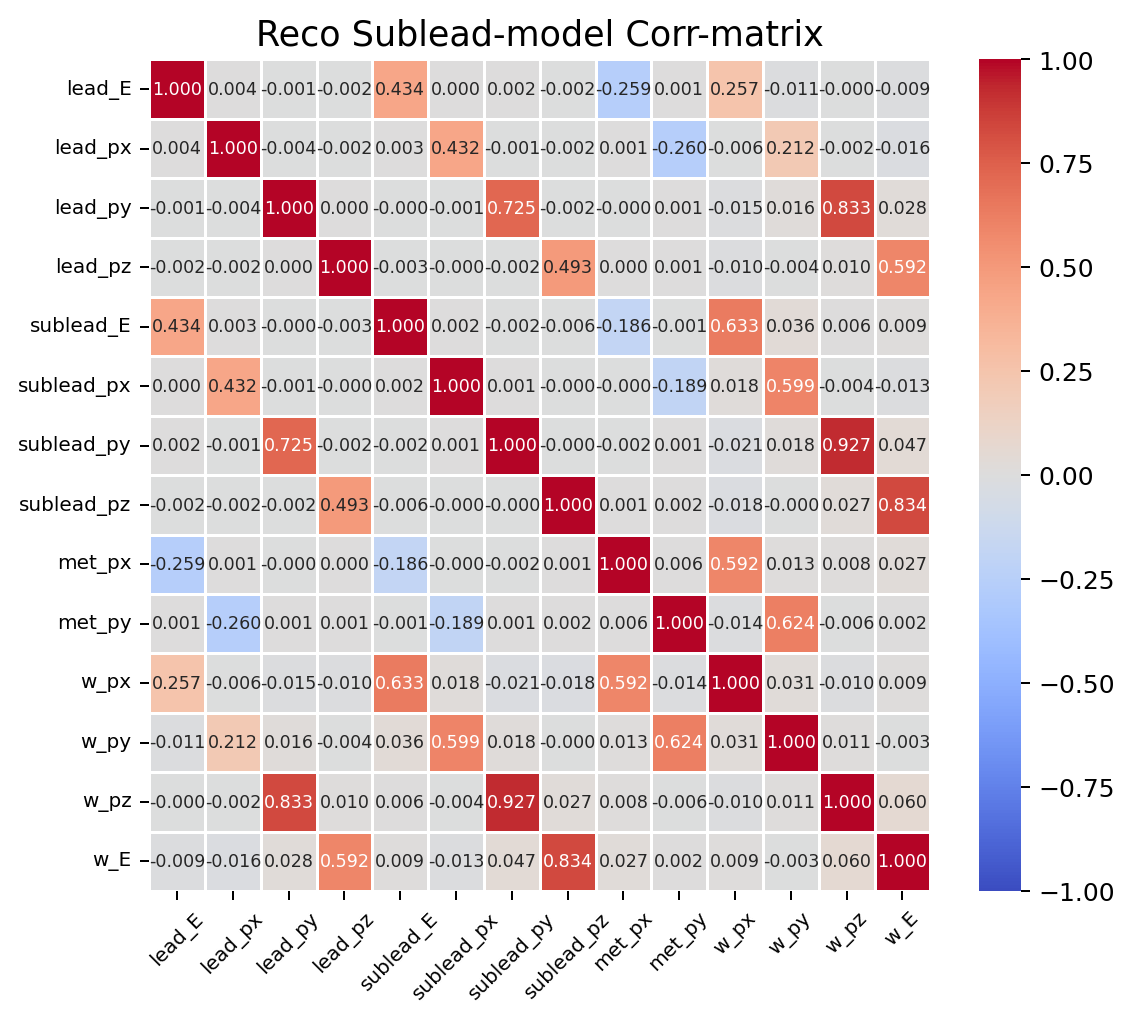

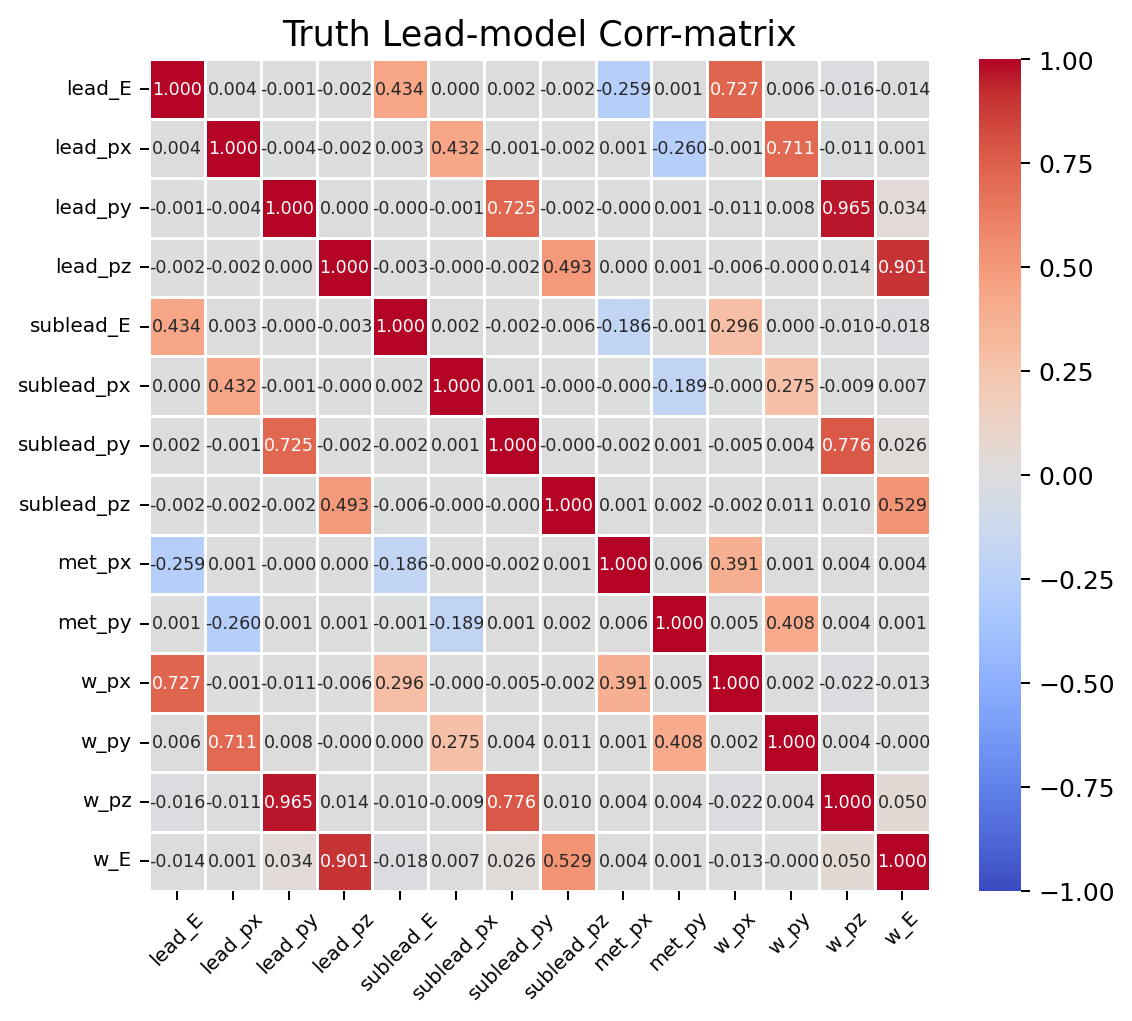

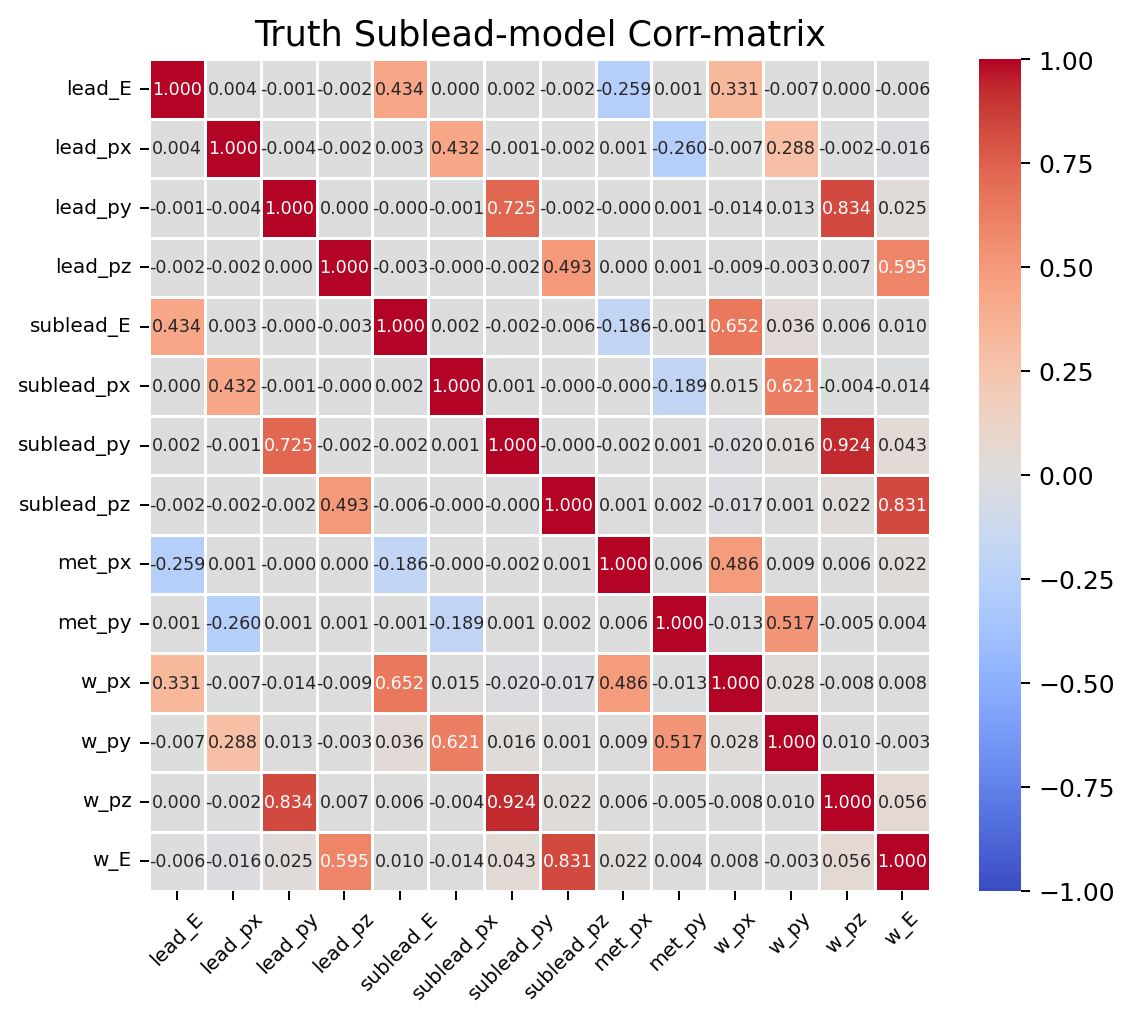

In [301]:
# reco
# lead
lead_model_cov_matrix = pred_lead_w.corr()
plt.figure(figsize=(7, 6), dpi=180)
ax = sn.heatmap(lead_model_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='white', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title('Reco Lead-model Corr-matrix', fontsize=14)
plt.show()
plt.close()
# sublead
sublead_model_cov_matrix = pred_sublead_w.corr()
plt.figure(figsize=(7, 6), dpi=180)
ax = sn.heatmap(sublead_model_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='white', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title('Reco Sublead-model Corr-matrix', fontsize=14)
plt.show()
plt.close()

# truth
# lead
truth_lead_model_cov_matrix = pred_truth_lead_w.corr()
plt.figure(figsize=(7, 6), dpi=180)
ax = sn.heatmap(truth_lead_model_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='white', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title('Truth Lead-model Corr-matrix', fontsize=14)
plt.show()
plt.close()
# sublead
truth_sublead_model_cov_matrix = pred_truth_sublead_w.corr()
plt.figure(figsize=(7, 6), dpi=180)
ax = sn.heatmap(truth_sublead_model_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='white', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title('Truth Sublead-model Corr-matrix', fontsize=14)
plt.show()
plt.close()

In [302]:
# # reco
# # lead
# lead_model_cov_matrix = pd.DataFrame(pred_lead_w).corr()
# filtered_cov_matrix = lead_model_cov_matrix.where(lead_model_cov_matrix.abs() >=0.5)
# plt.figure(figsize=(7, 6), dpi=180)
# ax = sn.heatmap(filtered_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='grey', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# plt.title('Reco Lead-model Corr-matrix', fontsize=14)
# plt.show()
# plt.close()
# # sublead
# sublead_model_cov_matrix = pd.DataFrame(pred_sublead_w).corr()
# filtered_cov_matrix = sublead_model_cov_matrix.where(sublead_model_cov_matrix.abs() >=0.5)
# plt.figure(figsize=(7, 6), dpi=180)
# ax = sn.heatmap(filtered_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='grey', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# plt.title('Reco Sublead-model Corr-matrix', fontsize=14)
# plt.show()
# plt.close()

# # truth
# # lead
# truth_lead_model_cov_matrix = pd.DataFrame(pred_truth_lead_w).corr()
# filtered_cov_matrix = truth_lead_model_cov_matrix.where(truth_lead_model_cov_matrix.abs() >=0.5)
# plt.figure(figsize=(7, 6), dpi=180)
# ax = sn.heatmap(filtered_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='grey', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# plt.title('Truth Lead-model Corr-matrix', fontsize=14)
# plt.show()
# plt.close()
# # sublead
# truth_sublead_model_cov_matrix = pd.DataFrame(pred_truth_sublead_w).corr()
# filtered_cov_matrix = truth_sublead_model_cov_matrix.where(truth_sublead_model_cov_matrix.abs() >=0.5)
# plt.figure(figsize=(7, 6), dpi=180)
# ax = sn.heatmap(filtered_cov_matrix, annot=True, fmt='.3f', linewidths=.5, linecolor='grey', cmap="coolwarm", annot_kws={"size": 7}, vmin=-1, vmax=1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
# plt.title('Truth Sublead-model Corr-matrix', fontsize=14)
# plt.show()
# plt.close()

In [303]:
# reco
# lead
lep_lead_px = lead_lep[:, 0] * GEV
lep_lead_py = lead_lep[:, 1] * GEV
lep_lead_pz = lead_lep[:, 2] * GEV
lep_lead_e = lead_lep[:, 3] * GEV
lep_lead_pt = pt(lep_lead_px, lep_lead_py)
lep_lead_eta = eta(lep_lead_px, lep_lead_py, lep_lead_pz)
lep_lead_phi = phi(lep_lead_px, lep_lead_py)
# sublead
lep_sublead_px = sublead_lep[:, 0] * GEV
lep_sublead_py = sublead_lep[:, 1] * GEV
lep_sublead_pz = sublead_lep[:, 2] * GEV
lep_sublead_e = sublead_lep[:, 3] * GEV
lep_sublead_pt = pt(lep_sublead_px, lep_sublead_py)
lep_sublead_eta = eta(lep_sublead_px, lep_sublead_py, lep_sublead_pz)
lep_sublead_phi = phi(lep_sublead_px, lep_sublead_py)

# truth
# lead
truth_lep_lead_px = truth_lead_lep[:, 0] * GEV
truth_lep_lead_py = truth_lead_lep[:, 1] * GEV
truth_lep_lead_pz = truth_lead_lep[:, 2] * GEV
truth_lep_lead_e = truth_lead_lep[:, 3] * GEV
truth_lep_lead_pt = pt(truth_lep_lead_px, truth_lep_lead_py)
truth_lep_lead_eta = eta(truth_lep_lead_px, truth_lep_lead_py, truth_lep_lead_pz)
truth_lep_lead_phi = phi(truth_lep_lead_px, truth_lep_lead_py)
# sublead
truth_lep_sublead_px = truth_sublead_lep[:, 0] * GEV
truth_lep_sublead_py = truth_sublead_lep[:, 1] * GEV
truth_lep_sublead_pz = truth_sublead_lep[:, 2] * GEV
truth_lep_sublead_e = truth_sublead_lep[:, 3] * GEV
truth_lep_sublead_pt = pt(truth_lep_sublead_px, truth_lep_sublead_py)
truth_lep_sublead_eta = eta(truth_lep_sublead_px, truth_lep_sublead_py, truth_lep_sublead_pz)
truth_lep_sublead_phi = phi(truth_lep_sublead_px, truth_lep_sublead_py)

In [304]:
def miss_plot(full_data, miss_data, title=r"$\eta_{lead}$", unit=None, density=True):
    bins = 120
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, full_data],
        bins=bins,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()


def miss_w_plot(
    pass_data, miss_data, raw_data, title=r"$\eta_{lead}$", unit=None, density=True
):
    bins = 120
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, pass_data],
        bins=bins,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    plt.hist(
        raw_data,
        bins=bins,
        density=density,
        alpha=1.0,
        label="label",
        histtype="step",
        stacked=False,
        color="grey"
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

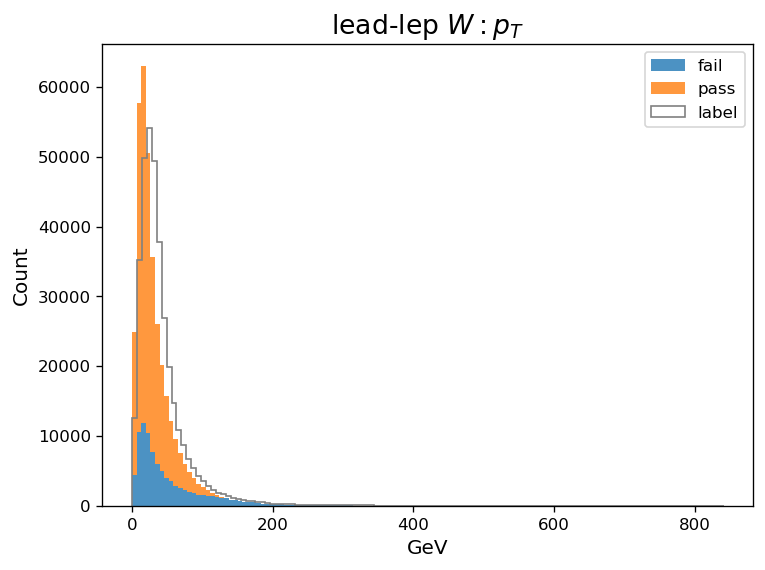

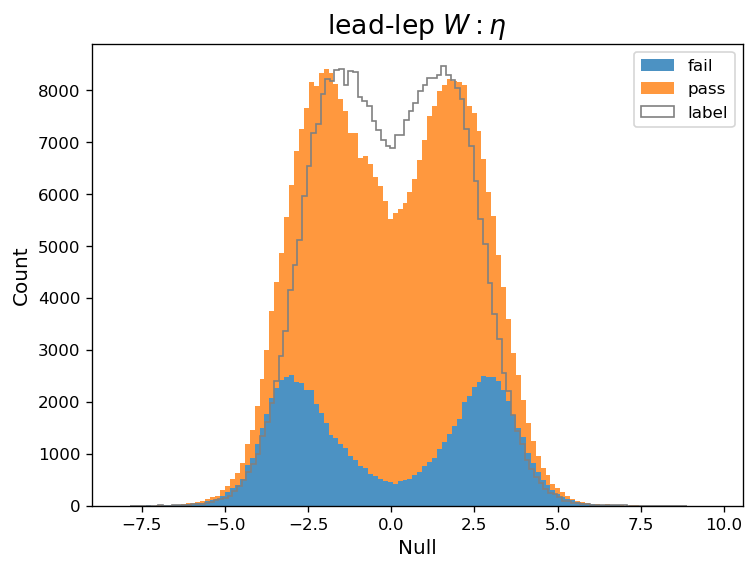

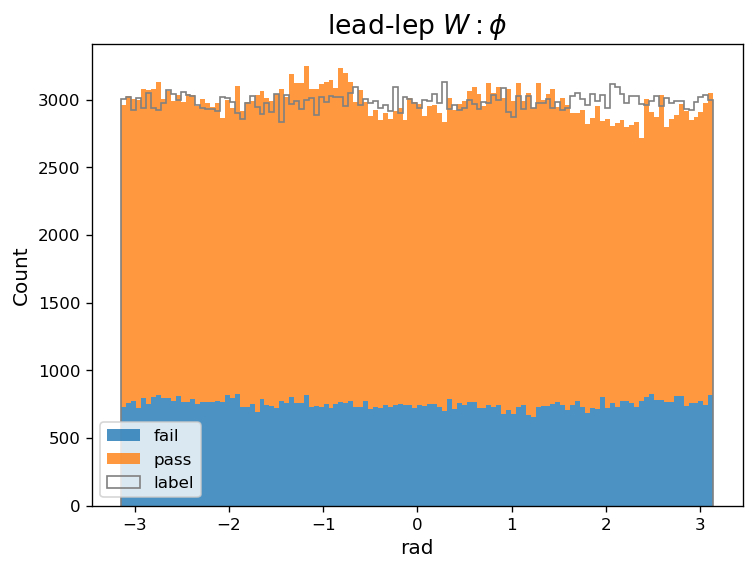

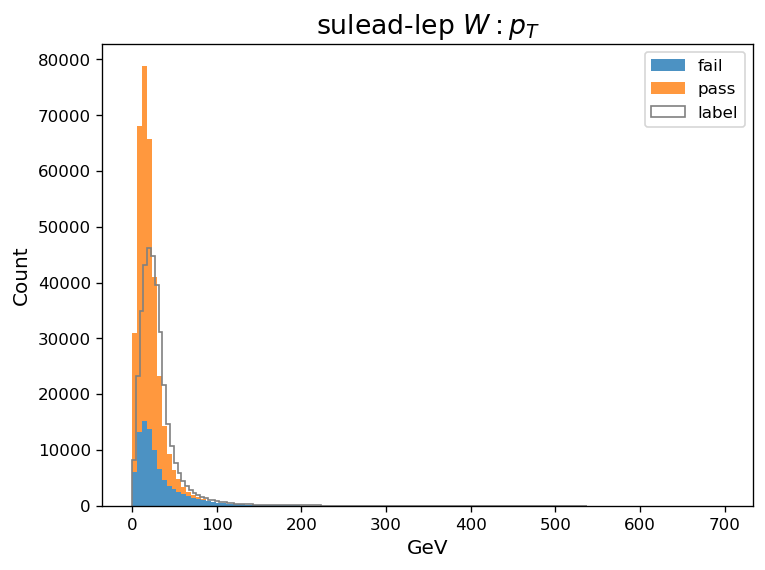

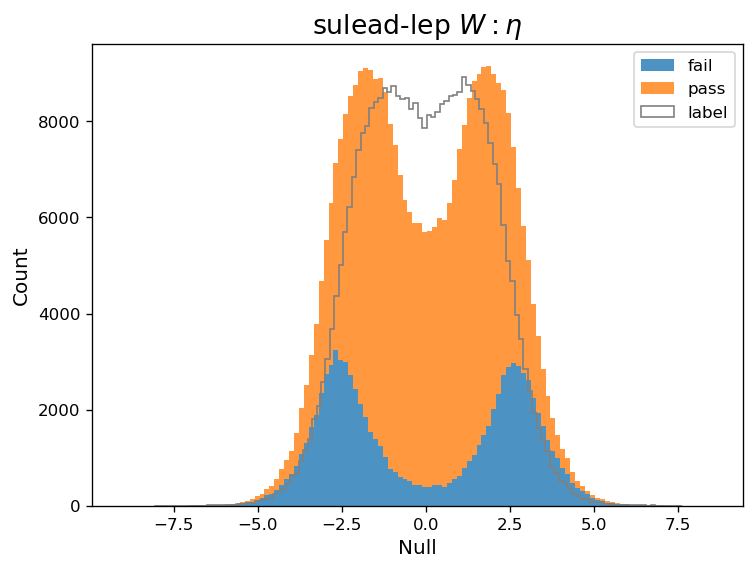

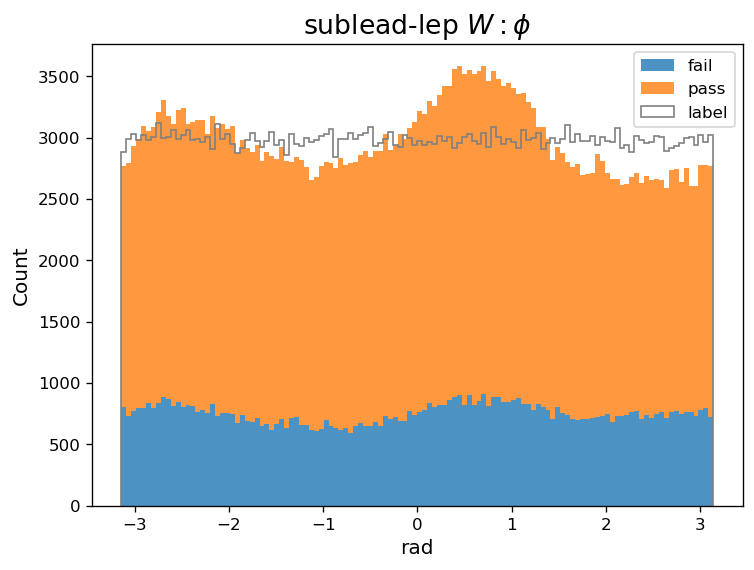

In [305]:
# lead
miss_w_plot(
    w_lead_pt[~mask],
    w_lead_pt[mask],
    raw_w_lead_pt,
    r"lead-lep $W: p_{T}$",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_lead_eta[~mask],
    w_lead_eta[mask],
    raw_w_lead_eta,
    r"lead-lep $W: \eta$",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_lead_phi[~mask],
    w_lead_phi[mask],
    raw_w_lead_phi,
    r"lead-lep $W: \phi$",
    unit="rad",
    density=False,
)

# sublead
miss_w_plot(
    w_sublead_pt[~mask],
    w_sublead_pt[mask],
    raw_w_sublead_pt,
    r"sulead-lep $W: p_{T}$",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_sublead_eta[~mask],
    w_sublead_eta[mask],
    raw_w_sublead_eta,
    r"sulead-lep $W: \eta$",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_sublead_phi[~mask],
    w_sublead_phi[mask],
    raw_w_sublead_phi,
    r"sublead-lep $W: \phi$",
    unit="rad",
    density=False,
)

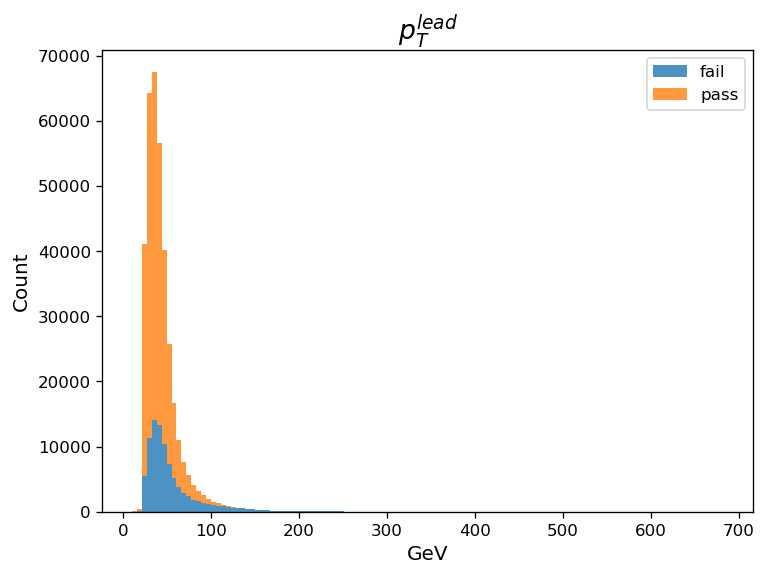

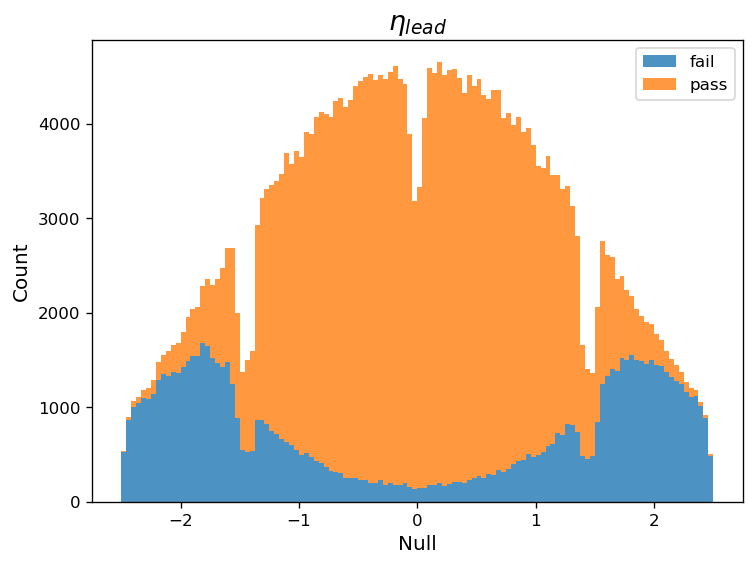

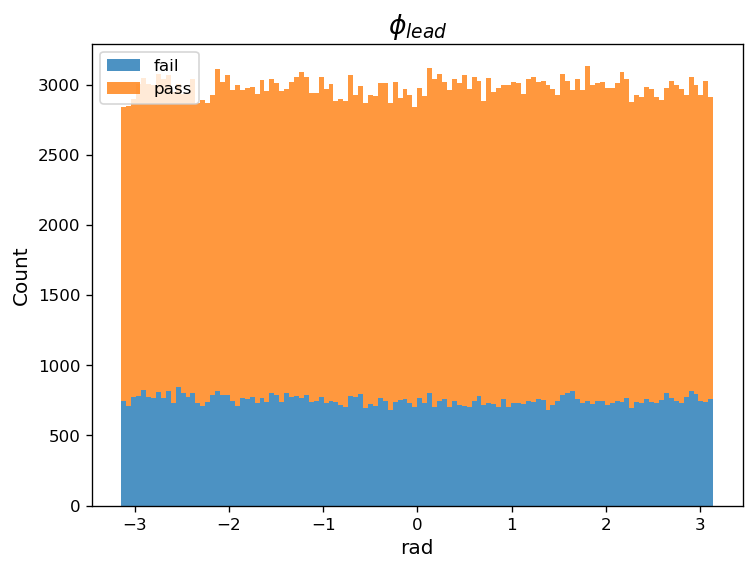

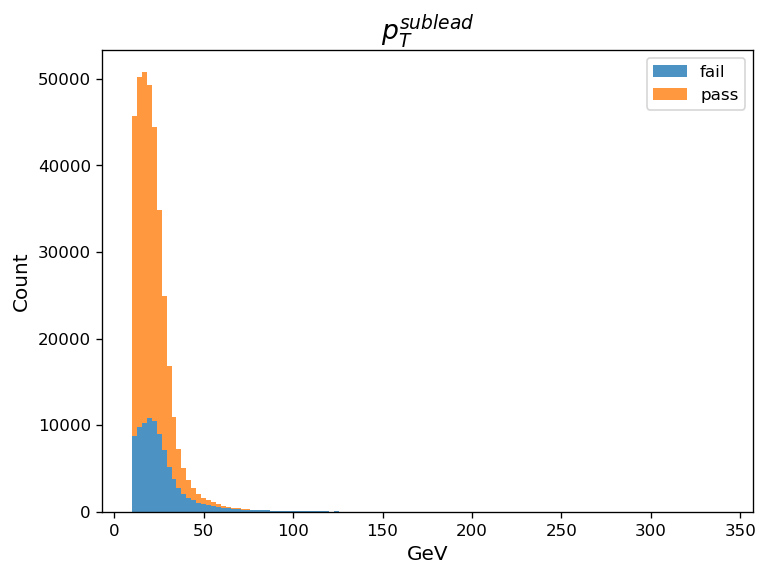

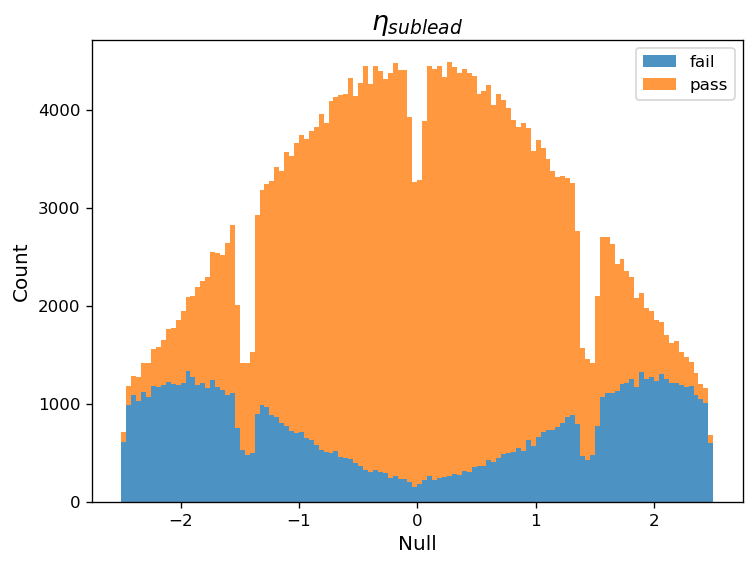

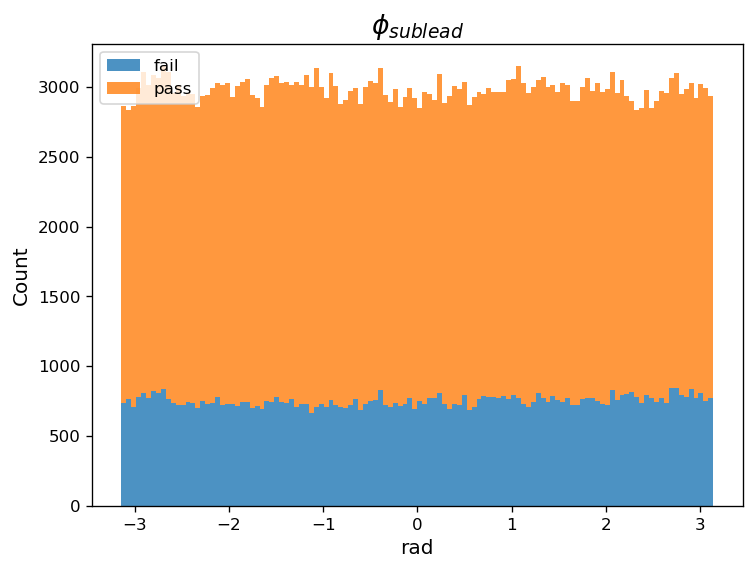

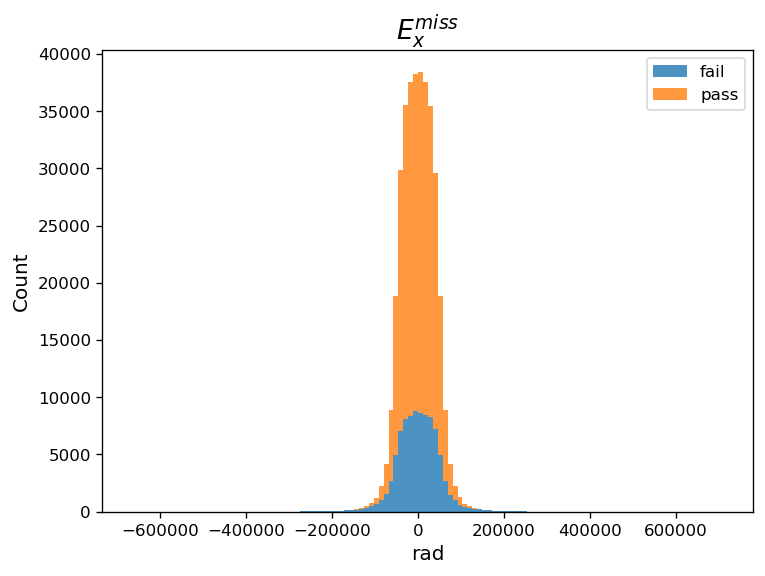

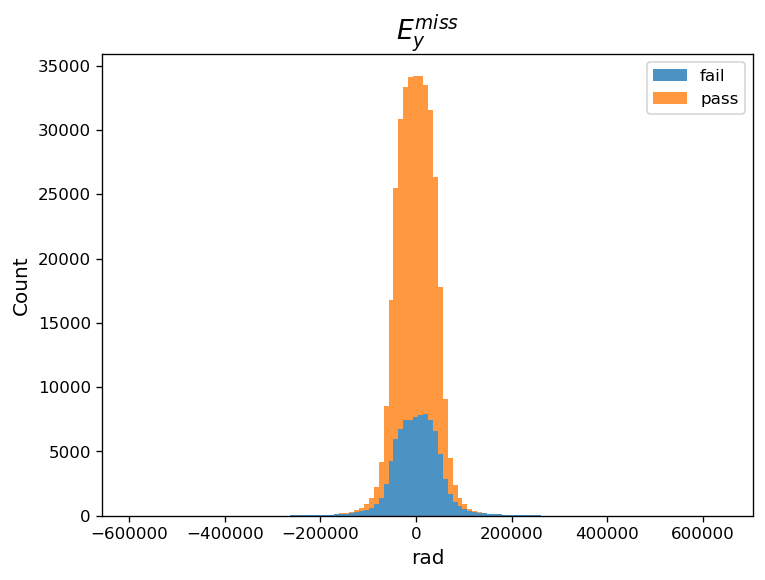

In [312]:
# lead
miss_plot(lep_lead_pt[~mask], lep_lead_pt[mask], r"$p_{T}^{lead}$", unit="GeV", density=False)
miss_plot(lep_lead_eta[~mask], lep_lead_eta[mask], r"$\eta_{lead}$", density=False)
miss_plot(lep_lead_phi[~mask], lep_lead_phi[mask], r"$\phi_{lead}$", unit="rad", density=False)
# sublead
miss_plot(lep_sublead_pt[~mask], lep_sublead_pt[mask], r"$p_{T}^{sublead}$", unit="GeV", density=False)
miss_plot(lep_sublead_eta[~mask], lep_sublead_eta[mask], r"$\eta_{sublead}$", density=False)
miss_plot(lep_sublead_phi[~mask], lep_sublead_phi[mask], r"$\phi_{sublead}$", unit="rad", density=False)
# met
miss_plot(met["RecoMETPx"][~mask], met["RecoMETPx"][mask], r"$E^{miss}_{x}$", unit="rad", density=False)
miss_plot(met["RecoMETPy"][~mask], met["RecoMETPy"][mask], r"$E^{miss}_{y}$", unit="rad", density=False)

In [309]:
t_end = time.time()
print(f"Total spending time: {t_end-t_start: .2f} (s)")

Total spending time:  176.90 (s)
